<a href="https://colab.research.google.com/github/Darkunquie/FMML_PROJECT_2024/blob/main/module%201%20lab%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Augmentation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X / 255
test_X = test_X / 255
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def NN1(traindata, trainlabel, query):
    diff = (
        traindata - query
    )
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label

In [5]:

def NN(traindata, trainlabel, testdata):
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    assert len(gtlabel) == len(
        predlabel
    )
    correct = (
        gtlabel == predlabel
    ).sum()
    return correct / len(gtlabel)

In [6]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Augmentation 1: Rotation


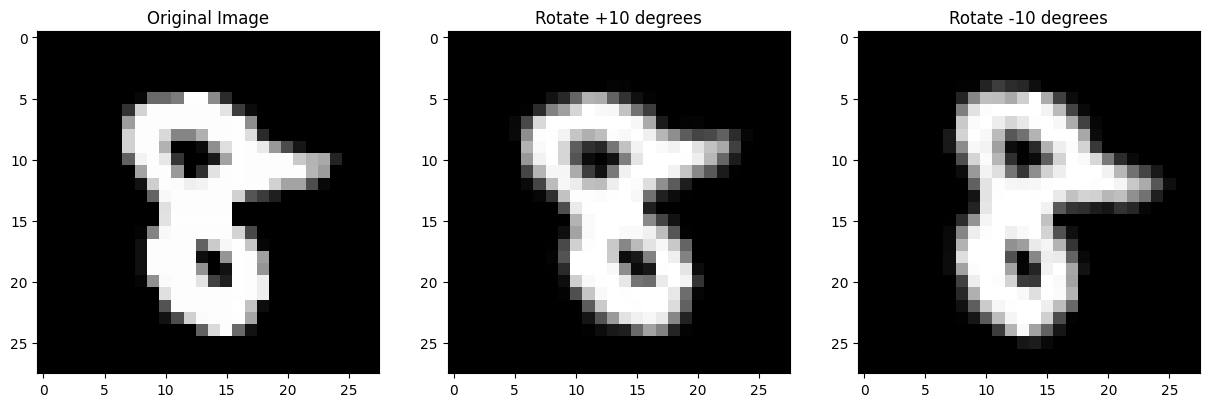

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

In [8]:
def augRotate(sample, angleconstraint):
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)

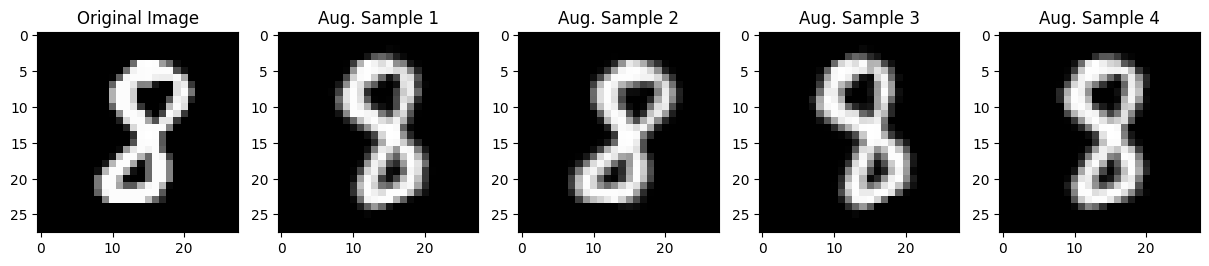

In [9]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

In [10]:

angleconstraint = 60
naugmentations = 5
augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )
    auglabel = np.concatenate(
        (auglabel, train_y)
    )
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


In [13]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)
for ii in range(len(angleconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 67.42 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.23 %
Accuracy after rotation augmentation constrained by 30 degrees is 67.58999999999999 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.78 %
Accuracy after rotation augmentation constrained by 50 degrees is 66.57 %
Accuracy after rotation augmentation constrained by 60 degrees is 66.96 %
Accuracy after rotation augmentation constrained by 70 degrees is 65.45 %
Accuracy after rotation augmentation constrained by 80 degrees is 65.55 %
Accuracy after rotation augmentation constrained by 90 degrees is 63.239999999999995 %


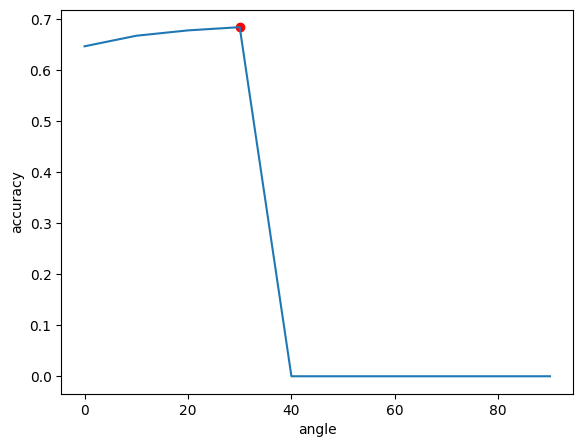

In [12]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

Augmentation 2: Shear

In [14]:
def shear(sample, amount):
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

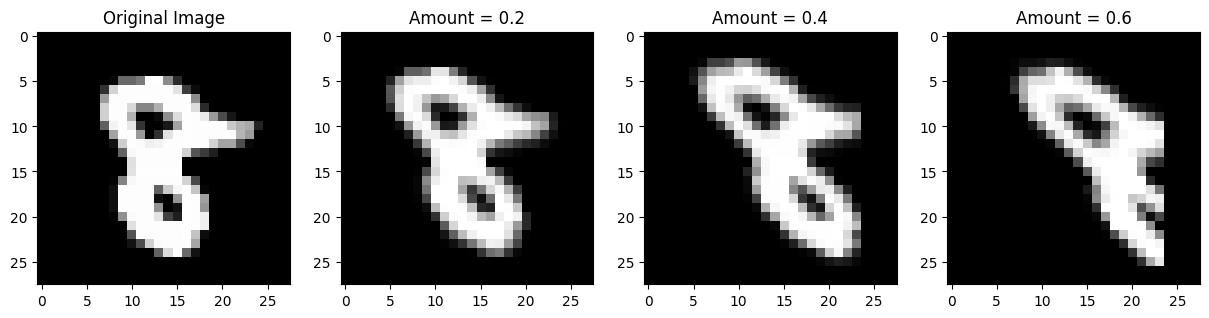

In [15]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

In [16]:
def augShear(sample, shearconstraint):
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)

In [17]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)

for ii in range(len(shearconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.029999999999994 %
Accuracy after shear augmentation constrained by 0.4 is 63.9 %
Accuracy after shear augmentation constrained by 0.6 is 64.42999999999999 %
Accuracy after shear augmentation constrained by 0.8 is 63.82 %
Accuracy after shear augmentation constrained by 1.0 is 63.99 %
Accuracy after shear augmentation constrained by 1.2 is 65.36 %
Accuracy after shear augmentation constrained by 1.4 is 63.33 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.05 %
Accuracy after shear augmentation constrained by 2.0 is 61.79 %


In [17]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

Augmentation 3: Rotation + Shear

In [18]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )
    return np.squeeze(nsample)

In [19]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]
angleconstraints = [0, 10, 20, 30, 40, 50, 60]
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)
for ii in range(len(hyp)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 59.64 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 58.10999999999999 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 59.699999999999996 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 59.45 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 60.8 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 61.57 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.33 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 59.46 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 60.6 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 60.29 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 62.06 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 58.940000000000005 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 61.91 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.449999999999996 %
Accuracy after augmentat

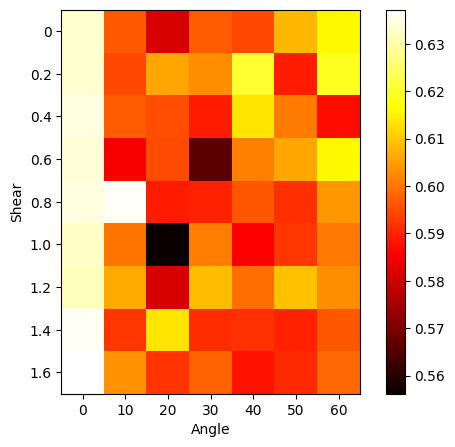

In [20]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

1. Best Values for Angle Constraint and Shear Constraint
The best values for angle and shear constraints will be highly dependent on the specific dataset and model you are using. For example:

Angle Constraint: Common values range from -20 to 20 degrees. You can start with smaller values, like ±10 degrees, and increase gradually.
Shear Constraint: This can vary from 0.1 to 0.3 in many scenarios. Again, starting with smaller values and increasing them can help you find an optimal range.
Experiment: You can run several trials with different ranges for each constraint and measure the model’s performance on validation data.

2.Adding data augmentations like rotation, flipping, scaling, and shearing can significantly improve model accuracy. You should compare the model's accuracy with and without these augmentations.

Example: If initially your model had an accuracy of 85%, after applying augmentations, it might increase to 90%. The exact improvement will depend on how well the augmentations match the variations in the test data.

3.Increasing the number of augmentations typically leads to better generalization. However, after a certain point, the returns might diminish, and training time will increase.

Experiment: Start by generating a few augmentations per sample (e.g., 3) and gradually increase (e.g., to 5, 10, etc.). Track the accuracy changes on a validation set to find an optimal balance.

4.Combining augmentations like rotation, scaling, and shear can create more robust models.

Experiment: Systematically combine different types of augmentations and evaluate performance on a validation set. For example, you might combine rotation and shearing and compare that against combinations of rotation, shear, and scaling. Smallest Training Dataset with Accuracy Above 50%
To find the smallest training dataset that still achieves accuracy above 50%, you will need to perform a series of down-sampling experiments:

Experiment: Start with a large, balanced dataset and gradually reduce its size while applying augmentations. Evaluate the model’s performance after each reduction.

exercise:

In [22]:
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape
from keras.utils import to_categorical

# Load Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Select 50 images per digit
x_small, y_small = [], []
for d in range(10):
    idxs = np.where(y_train == d)[0][:50]
    x_small.append(x_train[idxs])
    y_small.append(y_train[idxs])
x_small, y_small = np.concatenate(x_small), np.concatenate(y_small)

# Reshape data to add channel dimension
x_small = x_small.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Convert labels to categorical
y_small = to_categorical(y_small, 10)
y_test = to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_small)

# Model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training with data augmentation
model.fit(datagen.flow(x_small, y_small, batch_size=32),
          steps_per_epoch=len(x_small) // 32,
          epochs=10,
          validation_data=(x_test, y_test))

# Evaluate the performance
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
15/15 [==============================] - 8s 447ms/step - loss: 1.9128 - accuracy: 0.3098 - val_loss: 1.2015 - val_accuracy: 0.6286
Epoch 2/10
15/15 [==============================] - 6s 409ms/step - loss: 1.4075 - accuracy: 0.5256 - val_loss: 0.7796 - val_accuracy: 0.7734
Epoch 3/10
15/15 [==============================] - 4s 255ms/step - loss: 1.1752 - accuracy: 0.6303 - val_loss: 0.6563 - val_accuracy: 0.8190
Epoch 4/10
15/15 [==============================] - 3s 226ms/step - loss: 0.8778 - accuracy: 0.7244 - val_loss: 0.6423 - val_accuracy: 0.7882
Epoch 5/10
15/15 [==============================] - 3s 231ms/step - loss: 0.8970 - accuracy: 0.7125 - val_loss: 0.5718 - val_accuracy: 0.8197
Epoch 6/10
15/15 [==============================] - 4s 275ms/step - loss: 0.7243 - accuracy: 0.7692 - val_loss: 0.4974 - val_accuracy: 0.8476
Epoch 7/10
15/15 [==============================] - 3s 227ms/step - loss: 0.6744 - accuracy: 0.7991 - val_loss: 0.4941 - val_accuracy: 0.8415
Epoch 